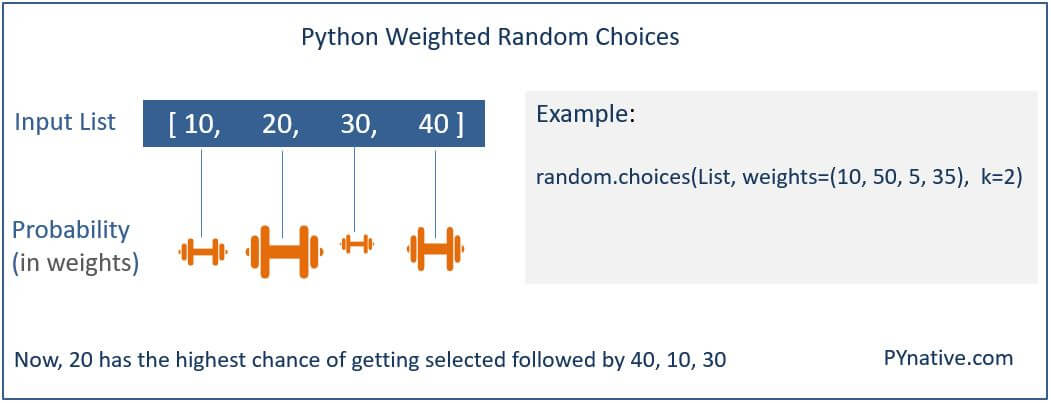

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
matplotlib.style.use('ggplot')

n = 1000
side = np.ceil(np.sqrt(n))
df = pd.DataFrame([(int(i % side), int(np.floor(i/side))) for i in range(n)], columns=['x', 'y'])


In [2]:
races = ["forestgreen", "dodgerblue", "darkred"]
# white denotes empty positions
choices = races + ["white"]
prob = [0.9/len(races) if i <=len(races)-1 else 0.1 for i in range(len(choices)) ]
df['race'] = random.choices(choices, weights = prob, k = n)


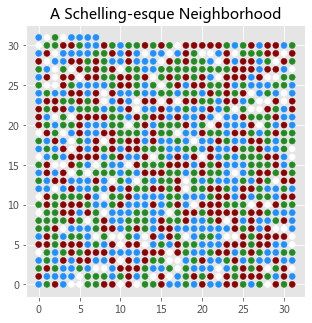

In [3]:
def PlotNeighborhood(df):
    plt.figure(figsize = [5, 5])
    plt.scatter(df['x'], df['y'], color=df['race'], marker='o')
    plt.title("A Schelling-esque Neighborhood")
    plt.show()
    
PlotNeighborhood(df)


In [4]:
def CountNeighbors(i):
    curr_x = i % side
    curr_y = np.floor(i / side)
    condition1 = df['x'].isin(range(int(curr_x) - depth, int(curr_x) + depth+1))
    condition2 = df['y'].isin(range(int(curr_y) - depth, int(curr_y) + depth+1))
    condition3 = ~ ((df['x']==curr_x) & (df['y']==curr_y))
    neighbors = df[(condition1) & (condition2) & (condition3)]
    num = [len(neighbors[neighbors['race']==i]) for i in races]
    num.append(np.sum(num))
    return num

In [5]:
# the depth of ege network
depth = 3
# Minimum fraction of own-race neighbors
fraction = 0.30
# Apply CountNeighbors to the entire data frame; append results to df
neighbors_list = [CountNeighbors(i) for i in range(n)]
df_neighbors = pd.DataFrame(neighbors_list, columns = ['forestgreen','dodgerblue','darkred','num.neighbors'])
df = pd.concat([df, df_neighbors],axis=1)


In [6]:
def GetPeopleWhoWantToMove(curr_race):
    # curr_race = darkred
    condition = (df['race'] == curr_race) & (df[curr_race]/df['num.neighbors'] < fraction)
    return df[condition].index


In [7]:
def AdjustNeighborCounts(row, race_of_mover, delta):
    # row = 3
    # race_of_mover = "darkred"
    # delta = 1
    curr_x = int(row) % side
    curr_y = np.floor(int(row)/side)
    condition1 = df['x'].isin(range(int(curr_x) - depth, int(curr_x) + depth+1))
    condition2 = df['y'].isin(range(int(curr_y) - depth, int(curr_y) + depth+1))
    condition3 = ~ ((df['x']==curr_x) & (df['y']==curr_y))
    row_index = df[(condition1) & (condition2) & (condition3)].index
    col_index = [race_of_mover, "num.neighbors"]
    df.loc[row_index, col_index]+=delta
    

In [8]:
def MoveOnePerson():
    # Returns 1 if a person was successfully moved, and 0 otherwise
    people_who_want_to_move =[j for i in races for j in GetPeopleWhoWantToMove(i).tolist()] 
    if ~len(people_who_want_to_move) >= 1: return 0
    # Of people who want to move, pick one uniformly at random
    person_who_will_move = random.sample(people_who_want_to_move, k=1)
    race_of_mover = df.loc[person_who_will_move, "race"]
    ## 
    condition = (df["race"]=="white")&(df[race_of_mover]/df["num.neighbors"] >=fraction)
    possible_new_homes = df[condition].index
    if ~len(possible_new_homes) >= 1: return 0
    # Of acceptable new homes, choose one uniformly at random
    new_home =random.sample(possible_new_homes.tolist(), k=1)
    df.loc[new_home, "race"] = race_of_mover
    df.loc[person_who_will_move, "race"] = "white"
    AdjustNeighborCounts(person_who_will_move[0], race_of_mover, -1)
    AdjustNeighborCounts(new_home[0], race_of_mover, +1)
    return 1

In [9]:
# people_who_want_to_move =[j for i in races for j in GetPeopleWhoWantToMove(i).tolist()] 
# person_who_will_move = random.sample(people_who_want_to_move, k=1)
# r = df.loc[person_who_will_move, 'race']
# race_of_mover = df.loc[person_who_will_move, "race"].values[0]
# print(race_of_mover)
# condition = (df["race"]=="white")&(df[race_of_mover]/df["num.neighbors"] >=fraction)
# possible_new_homes = df[condition].index
# print(possible_new_homes)
# new_home =random.sample(possible_new_homes.tolist(), k=1)
# print(person_who_will_move)


In [10]:
import sys
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()

In [11]:
def RunSimulation(max_movements):
    for i in range(1, max_movements+1):
        flushPrint(i)
        try:
            stop = MoveOnePerson()
        except:
            pass
    PlotNeighborhood(df)

    

1000

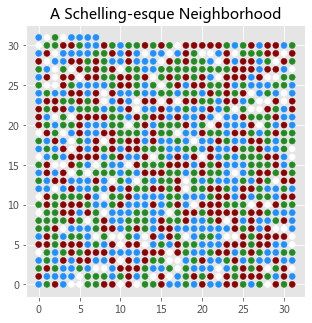

In [12]:
RunSimulation(max_movements=1000)

# The figure above is not correct!

Please revise the code above to get the right result similar to the following graph. 

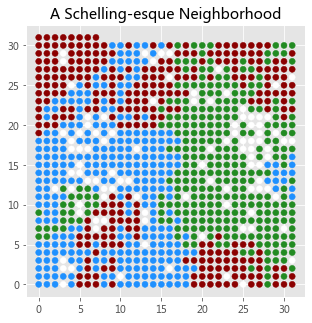

# Appendix.

The R script fo Schelling Models

```R
# Number of people
n <- 1000

# The people will live in a square with area side^2
side <- ceiling(sqrt(n))

df <- data.frame(x=((0:(n-1)) %% side),
                 y=floor((0:(n-1)) / side), row.names=0:(n-1))

# Most lots will have a race; some will be empty, ie uninhabited
races <- c("forestgreen", "dodgerblue", "darkred")

# Assign races iid uniformly; leave roughly 10% of lots empty
df$race <- sample(c(races, "empty"), n, replace=TRUE,
                  prob=c(rep(0.90 / length(races), length(races)),
                         0.10))

PlotNeighborhood <- function() {
  
  with(subset(df, race != "empty"),
       plot(x, y, col=race, pch=20, axes=FALSE,
            xlab="", ylab="", xlim=c(0, side), ylim=c(0, side),
            main="A Schelling-esque Neighborhood"))
  
}

dev.new(height=8, width=8)
par(mar=rep(1, 4), oma=rep(1, 4))
PlotNeighborhood()
savePlot("neighborhood_before_movement.png")

# Neighbors are counted within a Chebyshev distance <= depth
depth <- 3

CountNeighbors <- function(i) {
  
  # Count people of each race in person i's immediate neighborhood
  curr.x <- i %% side
  curr.y <- floor(i / side)
  neighbors <- subset(df, x %in% (curr.x - depth):(curr.x + depth) &
                        y %in% (curr.y - depth):(curr.y + depth) &
                        !(curr.x == x & curr.y == y))
  
  return(sapply(races, function(x) { sum(neighbors$race == x) }))
  
}

# Apply CountNeighbors to the entire data frame; append results to df
df <- cbind(df, t(sapply(0:(n - 1), CountNeighbors)))

df$num.neighbors <- rowSums(df[ , races])

# Minimum fraction of own-race neighbors
fraction <- 0.30

GetPeopleWhoWantToMove <- function(curr.race) {
  
  subset.who.want.to.move <-
    subset(df, race == curr.race &
             get(curr.race) / num.neighbors < fraction)
  
  return(rownames(subset.who.want.to.move))
  
}

AdjustNeighborCounts <- function(row, race.of.mover, delta) {
  
  curr.x <- as.integer(row) %% side
  curr.y <- floor(as.integer(row) / side)
  
  df[df$x %in% (curr.x - depth):(curr.x + depth) &
       df$y %in% (curr.y - depth):(curr.y + depth) &
       !(curr.x == df$x & curr.y == df$y),
     c(race.of.mover, "num.neighbors")] <<- 
    df[df$x %in% (curr.x - depth):(curr.x + depth) &
         df$y %in% (curr.y - depth):(curr.y + depth) &
         !(curr.x == df$x & curr.y == df$y),
       c(race.of.mover, "num.neighbors")] + delta
  
}

MoveOnePerson <- function() {
  
  # Returns 1 if a person was successfully moved, and 0 otherwise
  
  people.who.want.to.move <- c(lapply(races, GetPeopleWhoWantToMove),
                               recursive=TRUE)
  
  if (!length(people.who.want.to.move) >= 1) return(0)
  
  # Of people who want to move, pick one uniformly at random
  person.who.will.move <- sample(people.who.want.to.move, size=1)
  
  race.of.mover <- df$race[rownames(df) == person.who.will.move]
  
  possible.new.homes <- rownames(
    subset(df, race == "empty" &
             get(race.of.mover) / num.neighbors >= fraction))
  
  if (!length(possible.new.homes) >= 1) return(0)
  
  # Of acceptable new homes, choose one uniformly at random
  new.home <- sample(possible.new.homes, size=1)
  
  df[rownames(df) == new.home, ]$race <<- race.of.mover
  df[rownames(df) == person.who.will.move, ]$race <<- "empty"
  
  AdjustNeighborCounts(person.who.will.move, race.of.mover, -1)
  AdjustNeighborCounts(new.home, race.of.mover, +1)
  
  return(1)
  
}

RunSimulation <- function(max.movements = 5000, plots.in.loop=TRUE) {
  
  par(mar=rep(1, 4), oma=rep(1, 4))
  
  for(i in 1:max.movements) {
    
    if (!MoveOnePerson()) break
    if (plots.in.loop & (i %% 50) == 0) PlotNeighborhood()
    
  }
  
}

library(animation)

saveVideo(RunSimulation(),
          video.name="schelling_neighborhood_model.mp4",
          interval=0.20, outdir=getwd())

dev.new(height=8, width=8)
par(mar=rep(1, 4), oma=rep(1, 4))
PlotNeighborhood()
savePlot("neighborhood_after_movement.png")
```